<!-- # Copyright (c) 2024 Graphcore Ltd. All rights reserved. -->

# GFloat Basics

This notebook shows the use of `decode_float` to explore properties of some float formats.


In [1]:
# Install packages
from pandas import DataFrame
import numpy as np

from gfloat import decode_float
from gfloat.formats import *

## List all the values in a format

The first example shows how to list all values in a given format.
We will choose the [OCP](https://www.opencompute.org/documents/ocp-8-bit-floating-point-specification-ofp8-revision-1-0-2023-12-01-pdf-1) E5M2 format.

The object `format_info_ocp_e5m2` is from the `gfloat.formats` package, and describes the characteristics of that format:

In [2]:
format_info_ocp_e5m2

FormatInfo(name='ocp_e5m2', k=8, precision=3, bias=15, has_nz=True, domain=<Domain.Extended: 2>, num_high_nans=3, has_subnormals=True, is_signed=True, is_twos_complement=False)

We shall use the format to decode all values from 0..255, and gather them in a pandas DataFrame.
We see that `decode_float` returns a lot more than just the value - it also splits out the exponent, significand, and sign, and returns the `FloatClass`, which allows us to distinguish normal and subnormal numbers, as well as zero, infinity, and nan.

In [3]:
fmt = format_info_ocp_e5m2
vals = [decode_float(fmt, i) for i in range(256)]
DataFrame(vals).set_index("code")

,fval,exp,expval,significand,fsignificand,signbit,fclass
code,,,,,,,
0,0.000000e+00,0,-14,0,0.00,0,FloatClass.ZERO
1,1.525879e-05,0,-14,1,0.25,0,FloatClass.SUBNORMAL
2,3.051758e-05,0,-14,2,0.50,0,FloatClass.SUBNORMAL
3,4.577637e-05,0,-14,3,0.75,0,FloatClass.SUBNORMAL
4,6.103516e-05,1,-14,0,1.00,0,FloatClass.NORMAL
...,...,...,...,...,...,...,...
251,-5.734400e+04,30,15,3,1.75,1,FloatClass.NORMAL
252,-inf,31,16,0,1.00,1,FloatClass.INFINITE
253,NaN,31,16,1,1.25,1,FloatClass.NAN


## Plot the values in some 6-bit formats

This is a plot of the positive values in each format, as a function of their integer 
codepoint.  Subnormal values are indicated, illustrating the increased dynamic range 
they offer.  (More on this below.)

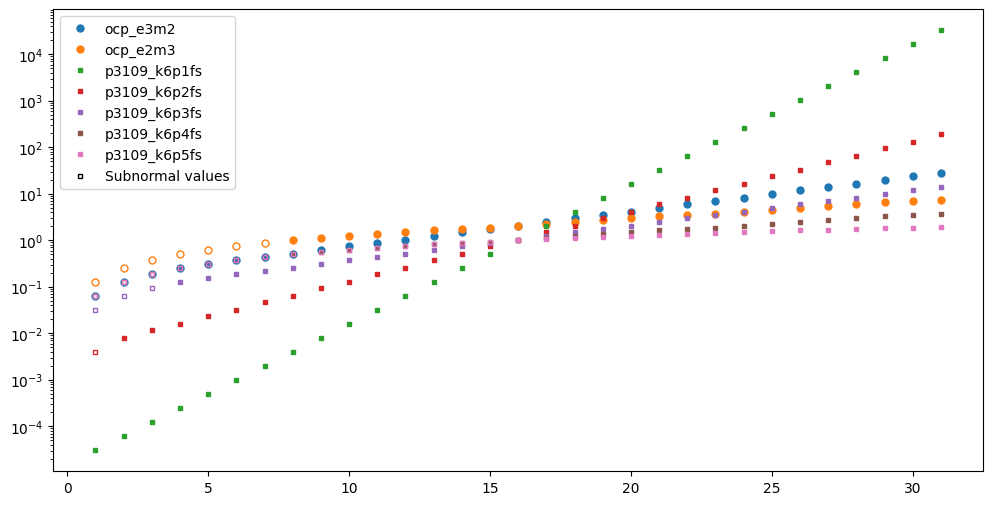

In [4]:
from matplotlib import pyplot as plt
from gfloat import decode_ndarray

plt.figure(figsize=(12, 6))
code = np.arange(0, 2**6)
for fi in (
    format_info_ocp_e3m2,
    format_info_ocp_e2m3,
    *(format_info_p3109(6, p, Domain.Finite) for p in range(1, 6)),
):
    val = decode_ndarray(fi, code)
    valid = (val > 0) & np.isfinite(val)
    subnormal = val < fi.smallest_normal
    if "ocp" in str(fi):
        nsty = dict(marker="o", markersize=5, linestyle="None")
        snsty = dict(marker="o", markersize=5, linestyle="None", markerfacecolor="none")
    else:
        nsty = dict(marker="s", markersize=3.5, linestyle="None")
        snsty = dict(marker="s", markersize=3.5, linestyle="None", markerfacecolor="none")
    (p,) = plt.plot(
        code[valid & ~subnormal], val[valid & ~subnormal], label=fi.name, **nsty
    )
    (hsub,) = plt.plot(
        code[valid & subnormal],
        val[valid & subnormal],
        label=None,
        color=p.get_color(),
        **snsty,
    )

plt.plot(np.nan, np.nan, label="Subnormal values", color="k", **snsty)
plt.yscale("log")
plt.legend()
None  # suppress output

## Additional format info: special values, min, max, dynamic range

In addition, `FormatInfo` can tell us about other characteristics of each format.
To reproduce some of the OCP spec's tables 1 and 2:

In [5]:
def compute_dynamic_range(fi):
    return np.log2(fi.max / fi.smallest)


for prop, probe in (
    ("Format                 ", lambda fi: fi.name.replace("format_info_", "")),
    ("Exponent bias          ", lambda fi: fi.bias),
    ("Infinities             ", lambda fi: 2 * fi.num_posinfs),
    ("Number of NaNs         ", lambda fi: fi.num_nans),
    ("Number of zeros        ", lambda fi: int(fi.has_zero) + int(fi.has_nz)),
    ("Max exponent (emax)    ", lambda fi: fi.emax),
    ("Max normal number      ", lambda fi: fi.max),
    ("Min normal number      ", lambda fi: fi.smallest_normal),
    ("Min subnormal number   ", lambda fi: fi.smallest_subnormal),
    ("Dynamic range (binades)", lambda x: round(compute_dynamic_range(x))),
):
    print(
        prop,
        f"{probe(format_info_ocp_e4m3):<20}",
        f"{probe(format_info_ocp_e5m2):<20}",
        f"{probe(format_info_p3109(8, 3))}",
    )

Format                  ocp_e4m3             ocp_e5m2             p3109_k8p3es
Exponent bias           7                    15                   16
Infinities              0                    2                    2
Number of NaNs          2                    6                    1
Number of zeros         2                    2                    1
Max exponent (emax)     8                    15                   15
Max normal number       448.0                57344.0              49152.0
Min normal number       0.015625             6.103515625e-05      3.0517578125e-05
Min subnormal number    0.001953125          1.52587890625e-05    7.62939453125e-06
Dynamic range (binades) 18                   32                   33


## How do subnormals affect dynamic range?

Most, if not all, low-precision formats include subnormal numbers, as they increase the number of values near zero, and increase dynamic range.
A natural question is "by how much?".  To answer this, we can create a mythical new format, a copy of `e4m3`, but with `has_subnormals` set to true.

In [6]:
import copy

e4m3_no_subnormals = copy.copy(format_info_ocp_e4m3)
e4m3_no_subnormals.has_subnormals = False

And now compute the dynamic range with and without:

In [7]:
dr_with = compute_dynamic_range(format_info_ocp_e4m3)
dr_without = compute_dynamic_range(e4m3_no_subnormals)

print(f"Dynamic range with subnormals = {dr_with}")
print(f"Dynamic range without subnormals = {dr_without}")
print(f"Ratio = {2**(dr_with - dr_without):.1f}")

Dynamic range with subnormals = 17.807354922057606
Dynamic range without subnormals = 15.637429920615292
Ratio = 4.5
